##__Projet : Microstructure des prix financiers__

## Modal SNA 2019-2020

### Peng-Wei Chen & Diane Béranger

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

## __Question 1__

In [0]:
#On définit nu, la loi des incréments

value_1 = np.array([-1, 1])
value_2 = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])

saut_1 = lambda x : value_1[np.random.randint(low=2, size=x)] #correspond à m=1
saut_2 = lambda x : value_2[np.random.randint(low=12, size=x)] #correspond à m=3

P0 = 35
T = 4*60*60 #conversion en secondes
lamb = 1/300

### Simulation de trajectoire

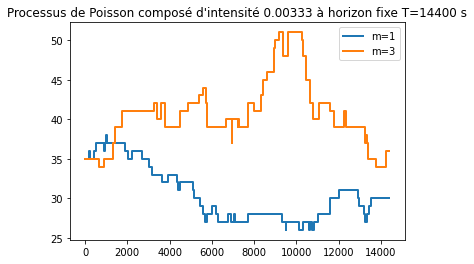

In [0]:
#Simulation des temps entre les sauts plutôt que directement N puis uniforme (évite d'avoir à trier en NlogN les temps des sauts)

def liste_sauts(lamb,T,P0,saut):
    liste_t= np.array([0,np.random.exponential(1/lamb)])
    liste_increments= np.array([0])
    while liste_t[-1]<T:
        liste_increments = np.append(liste_increments,saut(1))
        liste_t=np.append(liste_t,liste_t[-1]+np.random.exponential(1/lamb))
    liste_t[-1]= T
    liste_increments=np.append(liste_increments,0)
    liste_prix = P0 + np.cumsum(liste_increments)

    return liste_t,liste_prix


liste_t_1, liste_prix_1 = liste_sauts(lamb,T,P0,saut_1)
plt.step(liste_t_1, liste_prix_1, where="post", label="m=1", linewidth=2.0)

liste_t_2, liste_prix_2 = liste_sauts(lamb,T,P0,saut_2)
plt.step(liste_t_2, liste_prix_2, where="post", label="m=3", linewidth=2.0)
plt.title("Processus de Poisson composé d'intensité {:04.5f} à horizon fixe T={} s".format(lamb,T), fontsize=12)
plt.legend(loc="best")


### Question 1.1 : Probabilité de prix négatif

#### Méthode 1 - Monte-Carlo naïf

In [0]:
def liste_prix_sauts(lamb,T,P0,saut):
    N = np.random.poisson(lamb*T) #le nombre de sauts suit une loi de Poisson de paramètre lambda*T
    liste_increments = saut(N)
    liste_prix = P0 + np.cumsum(liste_increments)

    return liste_prix


def MC_naif(M,lamb,T,P0,saut): 
    liste_bool_inf_0 = np.zeros(M) 

    for l in range(M):
        liste_prix = liste_prix_sauts(lamb,T,P0,saut) #prix juste après les sauts
        if np.min(liste_prix) <0:
            liste_bool_inf_0[l] = 1

    p_r = np.mean(liste_bool_inf_0)
    return p_r


In [0]:
M = int(1e6)

p_r = MC_naif(M,lamb,T,P0,saut_2)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance
print("Estimation de la probabilité de ruine pour m=3 par la méthode de Monte-Carlo : {:07.6f}+/-{:07.6f}".format(p_r,R_IC))

Estimation de la probabilité de ruine pour m=3 par la méthode de Monte-Carlo : 0.004362+/-0.000129


#### Méthode 1-bis : Monte-Carlo optimisé

In [0]:
## Monte-Carlo Naif avec numba
from numba import jit

@jit(nopython=True)
def inf_echantillon(N, J, P0): # Function is compiled to machine code when called the first time
  ruines = 0
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        ruine = 1
        break
    ruines += ruine
  return ruines

def trajectoire(P0, T, lamb, saut, size):
  if size > int(1e7):
    sizes = size
    size = int(1e7)
    proba = 0
    for i in range(sizes // size):
      N = np.random.poisson(lam=lamb * T, size=size + 1)
      N[0] = 0
      N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                        # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
      J = saut(N[-1] + 1)
      res = inf_echantillon(N, J, P0)
      proba += res
    proba /= sizes
    return proba
  else:
    N = np.random.poisson(lam=lamb * T, size=size + 1)
    N[0] = 0
    N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                      # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
    J = saut(N[-1] + 1)
    res = inf_echantillon(N, J, P0)
    proba = res / size
    return proba

In [0]:
M = int(1e8)

p_r = trajectoire(P0, T, lamb, saut_1, size=M)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance

print("Estimation de la probabilité de ruine pour m=1 par méthode de Monte-Carlo accélérée: {:07.6f}+/-{:07.6f}".format(p_r,R_IC))


Estimation de la probabilité de ruine pour m=1 par méthode de Monte-Carlo accélérée: 0.000000+/-0.000000


In [0]:

M = int(1e7)

p_r = trajectoire(P0, T, lamb, saut_2, size=M)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance

print("Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: {:07.6f}+/-{:07.6f}".format(p_r,R_IC))

Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: 0.004359+/-0.000041


#### Méthode 2 - Echantillonnage d'importance

In [0]:
from numba import jit

@jit(nopython=True)# Function is compiled to machine code when called the first time
def inf_echantillon_importance(N, J, P0, lambT, s, f_dic): 
  ruines = 0.
  ruines_carre = 0.
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0.
    ruine_carre = 0.
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        # Calculer L_T
        X_T_f = np.sum(f_dic[ J[N[i]:N[i+1]] ])
        L_T = np.exp(X_T_f - (s - 1) * lambT)
        ruine = 1 / L_T
        ruine_carre = 1 / L_T / L_T
        break
    ruines += ruine
    ruines_carre += ruine_carre
  return ruines, ruines_carre

def trajectoire_importance(P0, T, lamb, m, size, f):
  if m == 1:
    value = np.array([-1, 1])
    p = np.array([1/2, 1/2])
  else:
    value = np.array([-3, -2, -1, 1, 2, 3])
    p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
    
  # Nouvelle loi
  s = np.sum(np.exp(f[value]) * p)
  new_lamb = lamb * s
  new_p = np.exp(f[value]) * p / s

  N = np.random.poisson(lam=new_lamb * T, size=size + 1)
  N[0] = 0
  N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
  
  J = np.random.choice(value, size=N[-1] + 1, p=new_p)
  ruines, ruines_carre = inf_echantillon_importance(N, J, P0, lamb * T, s, f)
  proba = ruines / size
  R_IC = 1.96 * np.sqrt(ruines_carre / size - proba * proba) / np.sqrt(size)
  return proba, R_IC

def meilleur_coeff(m, func, l_ = -100, r_ = 100):
    
    # f_dic : un map de p à f[p]. La forme étant [f[0], f[1], f[2], f[3], f[-3], f[-2], f[-1]] ou [f[0], f[1], f[-1]]
    if m == 3:
      value = np.array([-3, -2, -1, 1, 2, 3])
      p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
      f_dic = np.array([0, 1, 2, 3, -3, -2, -1])
    else:
      value = np.array([-1, 1])
      p = np.array([0.5, 0.5])
      f_dic = np.array([0, 1, -1])

    l = l_
    f = func(f_dic, l)
    print("Left bound for dichotomy : c =", l, "\tE_c[P_T] = ", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r = r_
    f = func(f_dic, r)
    print("Right bound for dichotomy : c =", r, "\tE_c[P_T] = ", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r_sign = np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    while r - l > 1e-8:
      c = (r + l) / 2
      f = func(f_dic, c)
      if np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p)) == r_sign:
        r = c
      else:
        l = c
    print("Final value of c = ", c, "\tE_c[P_T] = ", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    print()

    p_r, R_IC = trajectoire_importance(P0, T, lamb, m, M, f)

    print("Probabilité :", p_r)
    print("Rayon de l'intervalle de confiance :", R_IC)
    print("Intervalle de confiance : [{}, {}]".format(p_r - R_IC, p_r + R_IC))

In [0]:
m = 3
M = int(1e7)

# f(x) = c *  x 
meilleur_coeff(m, lambda x, c: x * c)
#On approche c tel que l'espérance du prix final est nulle par dichotomie
#puis on approche la probabilité de ruine 

Left bound for dichotomy : c = -100 	E_c[P_T] =  -4.8560659881031396e+129
Right bound for dichotomy : c = 100 	E_c[P_T] =  4.8560659881031396e+129
Final value of c =  -0.20969067118130624 	E_c[P_T] =  1.2587701991861877e-09

Probabilité : 0.004329118847811886
Rayon de l'intervalle de confiance : 7.143723429845608e-06
Intervalle de confiance : [0.00432197512438204, 0.0043362625712417315]


In [0]:
m = 1
M = int(1e7)

# f(x) = c *  x 
meilleur_coeff(m, lambda x, c: x * c)

Left bound for dichotomy : c = -100 	E_c[P_T] =  -1.3440585709080678e+43
Right bound for dichotomy : c = 100 	E_c[P_T] =  1.3440585709080678e+43
Final value of c =  -0.6763971236068755 	E_c[P_T] =  2.81506495891648e-09

Probabilité : 3.522720789166834e-07
Rayon de l'intervalle de confiance : 9.1361269764381e-10
Intervalle de confiance : [3.513584662190396e-07, 3.531856916143272e-07]


#### Méthode 3 - Splitting et MCMC 

In [0]:
#Version non optimisée

def NiveauxSplitting(a,seuil,n,lamb,T,p,P0,saut):

    """
    Fonction qui renvoie une estimation des niveaux
    de splitting a_1, a_2, ..., a_k tels que P(Phi_T <= a_k | Phi_T <= a_{k-1}) = 0.1 = seuil
    (où Phi_T : inf de P_t pour t dans [0;T])
    Ces niveaux sont des quantiles d'une loi conditionnelle.
    On utilise l'inversion de la fonction de repartition empirique de 
    cette loi afin d'estimer un quantile par
    le quantile empirique.
    On a a = a_k < a_{k-1} < ... < a_0= + infini (dans notre problème, a = 0)
    La fonction renvoie quantiles = [a_1, ..., a_k]
    """
    ## Estimation du premier niveau a_1: c'est le 
    ## quantile d'une loi non conditionnelle.
    ## On l'estime ici par la methode ergodique

    liste_Phi = np.zeros(n)

    liste_sauts = liste_sts(lamb,T,saut)

    for l in range(n):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_Phi[l] = Phi(liste_sauts,P0)

    liste_Phi.sort()

    quantiles = np.array([liste_Phi[int(np.ceil(seuil*n))-1]])    

    while quantiles[-1] > a:
        print("Inside while")
        liste_Phi = np.zeros(n)

        
        while Phi(liste_sauts,P0)>=quantiles[-1]:
            liste_sauts = liste_sts(lamb,T,saut)
        ## Simulation du processus AR(1) conditionnel
    
        for l in range(n):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            new_liste_sauts = tri_temps(new_liste_sauts)

            if Phi(new_liste_sauts,P0)<quantiles[-1]:
                liste_sauts = new_liste_sauts

            liste_Phi[l] = Phi(liste_sauts,P0)
    
        liste_Phi.sort()
        quantiles = np.append(quantiles, liste_Phi[int(np.ceil(seuil*n))-1] )

    
    ## On selectionne les niveaux a_{k-1},..., a_1 strictement au dessus de a
    quantiles = quantiles[:-1]
    ## On rajoute a
    quantiles = np.append(quantiles,a)

    return quantiles


def Phi(liste_sauts,P0):#fonction qui renvoie l'inf des valeurs de X aux instants de saut
    #ie l'inf de P0+cumsum(incréments) 
    if len(liste_sauts[0]) == 0:
        return P0
    liste_prix = P0+np.cumsum(liste_sauts[1,:])
    prix_min = np.min(liste_prix)
    return prix_min

def liste_sts(lbda,T,saut):
    
    N = np.random.poisson(lbda*T)
    liste_temps_sauts = np.random.uniform(low = 0, high = T, size = N)
    liste_temps_sauts_triee = [np.sort(liste_temps_sauts)]
    liste_increments = [saut(N)]
    #renvoie un array de N colonnes et 2 lignes: 1ere ligne pour les temps des sauts (T_n), deuxième ligne pour leurs amplitudes (J_n)
    return np.concatenate((liste_temps_sauts_triee,liste_increments),axis=0)

def tri_temps(new_liste_sauts):
    ordre = [new_liste_sauts[0,:].argsort()]
    liste_sauts_triee = np.take_along_axis(new_liste_sauts, np.concatenate((ordre,ordre),axis=0), axis=1) 
    return liste_sauts_triee


def MCMC(M,p,lamb,liste_a,P0,saut): 

    liste_pi = np.zeros(len(liste_a)) #estimateurs des probabilités conditionnelles

    liste_indicatrices = np.zeros(M,dtype=bool) 
    """
    le k-ieme élém. de liste_indicatrices vaut True si le prix devient négatif avant l'instant T lors du k-ieme essai; False sinon
    """

    #Loi non conditionnelle
    
    liste_sauts = liste_sts(lamb,T,saut) 


    for l in range(M):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_indicatrices[l] = (Phi(liste_sauts,P0)<liste_a[0])

    liste_pi[0] = np.mean(liste_indicatrices)
    
        


    for k in range(1,len(liste_a)):
        liste_indicatrices = np.zeros(M,dtype=bool)  

        #Initialisation 

        while Phi(liste_sauts,P0)>=liste_a[k-1]:
          
            liste_sauts = liste_sts(lamb,T,saut)

      
        for l in range(M):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            new_liste_sauts = tri_temps(new_liste_sauts)

            if Phi(new_liste_sauts,P0)< liste_a[k-1]:
                liste_sauts = new_liste_sauts
            liste_indicatrices[l] = (Phi(liste_sauts,P0) < liste_a[k])


        liste_pi[k] = np.mean(liste_indicatrices)
    

    proba_prix_negatif = np.prod(liste_pi)
        
    return proba_prix_negatif

In [0]:
#Version optimisée

def NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut):

    """
    Fonction qui renvoie une estimation des niveaux
    de splitting a_1, a_2, ..., a_k tels que P(Phi_T <= a_k | Phi_T <= a_{k-1}) = 0.1 = seuil
    (où Phi_T : inf de P_t pour t dans [0;T])
    Ces niveaux sont des quantiles d'une loi conditionnelle.
    On utilise l'inversion de la fonction de repartition empirique de 
    cette loi afin d'estimer un quantile par
    le quantile empirique.
    On a a = a_k < a_{k-1} < ... < a_0= + infini (dans notre problème, a = 0)
    La fonction renvoie quantiles = [a_1, ..., a_k]
    """
    ## Estimation du premier niveau a_1: c'est le 
    ## quantile d'une loi non conditionnelle.
    ## On l'estime ici par la methode ergodique

    liste_Phi = np.zeros(M1)

    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Phi_min = 100000
    
    for l in range(M1):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_Phi[l] = Phi(liste_sauts,P0)
        if liste_Phi[l] < Phi_min:
            liste_sauts_min = np.copy(liste_sauts)
            Phi_min = liste_Phi[l]

    liste_Phi.sort()
    
    quantiles = np.array([liste_Phi[int(np.ceil(seuil*M1))-1]])    

    while quantiles[-1] > a:
        #print("Inside while", quantiles[-1], Phi(liste_sauts_min, P0))
        if quantiles[-1] <= a + 1:
            quantiles = np.append(quantiles, a)
            break
        
        liste_Phi = np.zeros(M1)
        
        liste_sauts = np.copy(liste_sauts_min)
        phi_actual = Phi(liste_sauts, P0)
        Phi_min = 100000

        ## Simulation du processus AR(1) conditionnel
    
        for l in range(M1):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            
            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)
            
            phi_local = Phi(new_liste_sauts,P0)
            
            if phi_local<quantiles[-1]:
                liste_sauts = new_liste_sauts
                phi_actual = phi_local

            liste_Phi[l] = phi_actual
            if liste_Phi[l] < Phi_min:
                liste_sauts_min = np.copy(liste_sauts)
                Phi_min = liste_Phi[l]

        liste_Phi.sort()
        quantile = liste_Phi[int(np.ceil(seuil*M1)) - 1]
        if quantile >= quantiles[-1]:
            quantiles = np.append(quantiles, quantiles[-1] - 1)
        else:
            quantiles = np.append(quantiles, quantile)


    ## On selectionne les niveaux a_{k-1},..., a_1 strictement au dessus de a
    quantiles = quantiles[:-1]
    ## On rajoute a
    quantiles = np.append(quantiles,a)

    return quantiles


from numba import jit

@jit(nopython=True)
def Phi(liste_sauts, P0): # Function is compiled to machine code when called the first time
    prix_min = P0
    if len(liste_sauts[0]) == 0:
        return P0
    for i in liste_sauts[1, :]:
        P0 += i
        if P0 < prix_min:
            prix_min = P0
    return prix_min

'''def Phi(liste_sauts,P0):#fonction qui renvoie l'inf des valeurs de X aux instants de saut
    #ie l'inf de P0+cumsum(incréments) 
    if len(liste_sauts[0]) == 0:
        return P0
    liste_prix = P0+np.cumsum(liste_sauts[1,:])
    prix_min = np.min(liste_prix)
    return prix_min'''

def liste_sts(lbda, T, saut):
    N = np.random.poisson(lbda*T)
    liste_sauts = np.zeros((2, N))
    liste_sauts[0, :] = np.sort(np.random.uniform(low=0, high=T, size=N))
    liste_sauts[1, :] = saut(N)
    #renvoie un array de N colonnes et 2 lignes: 1ere ligne pour les temps des sauts (T_n), deuxième ligne pour leurs amplitudes (J_n)
    return liste_sauts
    #liste_temps_sauts = np.random.uniform(low = 0, high = T, size = N)
    #liste_temps_sauts_triee = [np.sort(liste_temps_sauts)]
    #liste_increments = [saut(N)]
    #return np.concatenate((liste_temps_sauts_triee,liste_increments),axis=0)

@jit(nopython=True)
def new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt):
    i = 0
    j = 0
    k = 0
    # Merge two listes triées
    while i < nc:
        T1 = coloriage[0, i]
        while j < nt and liste_sauts_tilde[0, j] < T1:
            new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
            j += 1
            k += 1
        new_liste_sauts[:, k] = coloriage[:, i]
        i += 1
        k += 1
    while j < nt:
        new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
        j += 1
        k += 1
    return new_liste_sauts

def tri_temps(new_liste_sauts):
    ordre = [new_liste_sauts[0,:].argsort()]
    liste_sauts_triee = np.take_along_axis(new_liste_sauts, np.concatenate((ordre,ordre),axis=0), axis=1) 
    return liste_sauts_triee


def MCMC(M2,p,lamb,liste_a,P0,saut):

    liste_pi = np.zeros(len(liste_a)) #estimateurs des probabilités conditionnelles

    liste_indicatrices = np.zeros(M2,dtype=bool) 
    """
    le k-ieme élém. de liste_indicatrices vaut True si le prix devient négatif avant l'instant T lors du k-ieme essai; False sinon
    """

    #Loi non conditionnelle
    
    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Found = False

    for l in range(M2):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        if Phi(liste_sauts, P0) < liste_a[0]:
            liste_indicatrices[l] = True
            if not Found:
                liste_sauts_min = np.copy(liste_sauts)
                Found = True

    liste_pi[0] = np.mean(liste_indicatrices)
    
    for k in range(1,len(liste_a)):
        liste_indicatrices = np.zeros(M2,dtype=bool)  

        #Initialisation 
        liste_sauts = np.copy(liste_sauts_min)
        phi_actual = Phi(liste_sauts, P0)
        
        Found = False

        for l in range(M2):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)

            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)

            phi_local = Phi(new_liste_sauts, P0)
            
            if phi_local < liste_a[k-1]:
                liste_sauts = new_liste_sauts
                phi_actual = phi_local

            if phi_actual < liste_a[k]:
                liste_indicatrices[l] = True
                if not Found:
                    liste_sauts_min = np.copy(liste_sauts)

        liste_pi[k] = np.mean(liste_indicatrices)
    
    proba_prix_negatif = np.prod(liste_pi)
    return proba_prix_negatif

In [0]:
%%time

M = int(1e4) 
a=0

#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
seuil = 0.02 #Choisi pour avoir 4 niveaux de Splitting
p=0.89

liste_a = NiveauxSplitting(a,seuil,M,lamb,T,p,P0,saut_1) #exemple: [19. 10.  3.  0.] pour M = 10^4, seuil=0.02 et p=0.5
print("Niveaux de splitting : ",liste_a)

n=10
probas = np.zeros(n)
M2 = int(1e4)

for i in range(n):
    probas[i] = MCMC(M2, p,lamb,liste_a,P0,saut_1)

p_r = np.mean(probas)
sigma_emp = np.std(probas)/np.sqrt(n) #écart-type empirique de la moyenne des n estimateurs
print("Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(p_r,sigma_emp))

Niveaux de splitting :  [19. 10.  3.  0.]
Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: 0.00000033+/-0.00000002
CPU times: user 25.7 s, sys: 21.1 ms, total: 25.7 s
Wall time: 25.7 s


In [0]:
M = int(1e4) 

a=0


#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
seuil = 0.2
p=0.5

liste_a = NiveauxSplitting(a,seuil,M,lamb,T,p,P0,saut_2)
print("Niveaux de splitting : ",liste_a)

n=10
probas = np.zeros(n)
M2 = int(1e4)


for i in range(n):
    probas[i] = MCMC(M2, p,lamb,liste_a,P0,saut_2)

p_r = np.mean(probas)
sigma_emp = np.std(probas)/np.sqrt(n) #écart-type empirique de la moyenne des n estimateurs

print("Estimation de la probabilité de ruine pour m=3 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(p_r,sigma_emp))

Niveaux de splitting :  [19.  9.  1.  0.]
Estimation de la probabilité de ruine pour m=3 par méthode de Splitting/MCMC: 0.00409199+/-0.00006778


###  Question 1.2 : Quantile


In [0]:
#Naif - Méthode 1

def Quantile_naif(seuil,n,lamb,T,P0,k,saut):

    liste_P_t = np.zeros(n)
    for i in range(n):
        N = np.random.poisson(lamb*T)
        increments = saut(N)
        
        liste_P_t[i] = np.sum(increments)+P0
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(n*seuil))-1]

In [0]:
#Accéléré - Méthode 2

# Poisson composé naïf
def Poisson_compose(P0, T, lamb, saut, size):
  # saut : une fonction qui prend la taille de sortie comme entrée pour les sauts.
  N = np.random.poisson(lam=lamb * T, size=size + 1)
  N[0] = 0
  N = np.cumsum(N)                  # La valeur N[i] - N[i - 1] est égale à N pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] + 1 et N[i + 1] suit la loi voulue
  J = saut(N[-1] + 1)               # Sauts
  J = np.cumsum(J)
  M = J[N[1:]] - J[N[:-1]]          # On veut la somme entre l'indice N[i] + 1 et N[i + 1]
  return P0 + M # échantillon de taille (size)

def quantile(echantillion, size, quant):
  index_bot = int(math.ceil(size * quant))
  index_top = int(math.ceil(size * (1 - quant)))
  echantillion.partition((index_bot, index_top))
  return echantillion[index_bot], echantillion[index_top]

def Question1_2_naive(size, quant, saut, P0, T, lamb):
  return quantile(Poisson_compose(P0, T, lamb, saut, size), size, quant)

In [0]:
#Ergodique - Méthode 3

def Quantile_ergodique(seuil,n,lamb,T,p,P0,saut): #renvoie le quantile de niveau "seuil" du processus de poisson composé

    liste_prix_final = np.zeros(n)

    liste_sauts = liste_sts(lamb,T,saut) 

    for l in range(n):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        liste_sauts = tri_temps(new_liste_sauts)

        liste_prix_final[l] = np.cumsum(liste_sauts[1,:])[-1] +P0

    liste_prix_final.sort()
  
    quantile = liste_prix_final[int(np.ceil(seuil*n))-1]    

  
    return quantile

In [0]:
#Exemple

n = int(1e6) 
niveau = 1e-4
p=0.5

quantileGauche = Quantile_ergodique(niveau,n,lamb,T,p,P0,saut_2) 
quantileDroit = Quantile_ergodique(1-niveau,n,lamb,T,p,P0,saut_2)
print("Quantiles gauche et droit de niveau {} estimés par MCMC pour m=3 : {} et {}".format(niveau,quantileGauche,quantileDroit))

Quantiles gauche et droit de niveau 0.0001 estimés par MCMC pour m=3 : -13.0 et 83.0


## __Question 2__

In [0]:
value_1 = np.array([-1, 1])
value_2 = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])

saut_1 = lambda x : value_1[np.random.randint(low=2, size=x)] #correspond à m=1
saut_2 = lambda x : value_2[np.random.randint(low=12, size=x)] #correspond à m=3

P0 = 35
T = 4*60*60
lamb1 = 1/660
lamb2 = 1/110

### Simulation de trajectoire

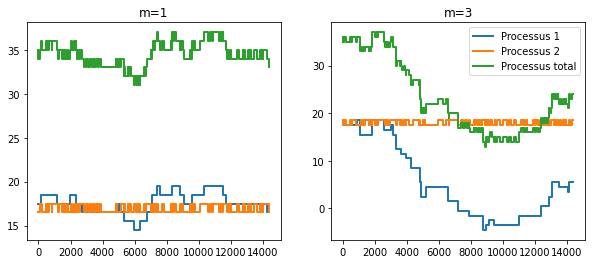

In [0]:
#Simulation des temps entre les sauts plutôt que directement N puis uniforme (évite d'avoir à trier en NlogN les temps des sauts)

def liste_sauts(lamb1,lamb2,T,P0,saut):
    liste_t1= np.array([0,np.random.exponential(1/lamb1)])
    liste_t2= np.array([0,np.random.exponential(1/lamb2)])

    liste_increments1= np.array([0])
    liste_increments2 = -1+2*np.random.binomial(1,0.5,1)
    while liste_t1[-1]<T:
        liste_increments1 = np.append(liste_increments1,saut(1))
        liste_t1=np.append(liste_t1,liste_t1[-1]+np.random.exponential(1/lamb1))
    liste_t1[-1]= T
    liste_increments1=np.append(liste_increments1,0)
    liste_prix1 = P0/2 + np.cumsum(liste_increments1)

    while liste_t2[-1]<T:
        liste_increments2 = np.append(liste_increments2,-liste_increments2[-1])
        liste_t2=np.append(liste_t2,liste_t2[-1]+np.random.exponential(1/lamb2))

    liste_t2[-1]= T
    liste_increments2=np.append(liste_increments2,0)
    liste_prix2 = P0/2 + np.cumsum(liste_increments2)

    liste_t = np.concatenate((liste_t1[:-1],liste_t2[:-1]))
    liste_increments = np.concatenate((liste_increments1[:-1],liste_increments2[:-1]))
    arg = np.argsort(liste_t)
    liste_t = liste_t[arg]
    liste_increments = liste_increments[arg]

    liste_increments = np.append(liste_increments,0)
    liste_t = np.append(liste_t,T)
    liste_prix = P0 + np.cumsum(liste_increments)

    return liste_t1, liste_prix1,liste_t2,liste_prix2,liste_t,liste_prix

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
liste_t1, liste_prix1,liste_t2,liste_prix2,liste_t,liste_prix = liste_sauts(lamb1,lamb2,T,P0,saut_1)
plt.step(liste_t1, liste_prix1, where="post", label="Processus 1", linewidth=2.0)

plt.step(liste_t2, liste_prix2, where="post", label="Processus 2", linewidth=2.0)
plt.step(liste_t, liste_prix, where="post", label="Processus total", linewidth=2.0)
plt.title("m=1", fontsize=12)

plt.subplot(1, 2, 2)
liste_t1, liste_prix1,liste_t2,liste_prix2,liste_t,liste_prix = liste_sauts(lamb1,lamb2,T,P0,saut_2)
plt.step(liste_t1, liste_prix1, where="post", label="Processus 1", linewidth=2.0)

plt.step(liste_t2, liste_prix2, where="post", label="Processus 2", linewidth=2.0)
plt.step(liste_t, liste_prix, where="post", label="Processus total", linewidth=2.0)
plt.title("m=3", fontsize=12)


plt.legend(loc="best")


### Question 2.1 : Probabilité de prix négatif

####Méthode 1 - MC Naif

In [0]:
def ruine(lamb1,lamb2,T,P0,saut):
    N1 = np.random.poisson(lamb1*T)
    N2 = np.random.poisson(lamb2*T)
    ind_2 = np.sort(np.random.choice(np.arange(N1+N2),replace=False,size=N2)) #indices des sauts du processus 2
    one_first = np.random.binomial(1,0.5) #pour savoir si le premier incrément du processus 2 vaut 1 ou -1

    increments=saut(N1+N2)

    for i in range(N2):
        increments[ind_2[i]] = -1+ 2*((i+one_first)%2)
    liste_prix = P0 + np.cumsum(increments)

    inf_P = np.min(liste_prix)
    if inf_P<0:
        return 1
    return 0


def MC_naif(M,lamb1,lamb2,T,P0,saut): 
    liste_ruine = np.zeros(M) 

    for l in range(M):
        liste_ruine[l] = ruine(lamb1,lamb2,T,P0,saut) 


    proba_prix_negatif = np.mean(liste_ruine)
    return proba_prix_negatif

In [0]:
%%time
M=int(1e6)

p_r = MC_naif(M,lamb1,lamb2,T,P0,saut_2)
R_IC = 1.96*np.sqrt(p_r*(1-p_r)/M)
print("Probabilité de ruine pour m=3 : {} +/- {}".format(p_r,R_IC))

Probabilité de ruine pour m=3 : 4.6e-05 +/- 1.3293061015973708e-05
CPU times: user 1min 49s, sys: 18 ms, total: 1min 49s
Wall time: 1min 49s


#### Méthode 1 bis - Monte-Carlo accéléré

In [0]:
#Monte-Carlo accéléré - Méthode 2
from numba import jit
from numpy.random import exponential

@jit(nopython=True)
def Q2_1_MC(P0, T, m):
  if m == 1:
    value = np.array([-1, 1])
    low = 2
  else:
    value = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])
    low = 12
  J2_0 = np.array([-1, 1])[np.random.randint(low=2)]

  somme = P0
  T1 = exponential(660)
  T2 = exponential(110)
  while T1 < T:
    while T2 < T1:
      somme += J2_0
      if somme < 0:
        return 1
      J2_0 *= -1
      T2 += exponential(110)
    somme += value[np.random.randint(low=low)]
    if somme < 0:
      return 1
    T1 += exponential(660)
  return 0

def Q2_1_MC_n(P0, T, m, size):
  somme = 0
  for i in range(size):
    somme += Q2_1_MC(P0, T, m)
  return somme / size

In [0]:
%%time
M=int(1e6)
m = 3

p_r = Q2_1_MC_n(P0, T, m, M)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance

print("Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: {:09.8f}+/-{:09.8f}".format(p_r,R_IC))

Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: 0.00004500+/-0.00001315
CPU times: user 12.2 s, sys: 22 ms, total: 12.3 s
Wall time: 12.3 s


#### Méthode 2 - Echantillonnage d'importance

In [0]:
def ruine(lamb1,lamb2,T,P0,c,increment1_c,esp):
    #returns 0,0 if no price is strictly negative
    #returns 1, 1/L_T otherwise

    t1=np.random.exponential(1/lamb1/esp)
    t2=np.random.exponential(1/lamb2)
    P = P0
    Pmin=P0

    sumIncrements1=0
    increment2 = -1+2*np.random.binomial(1,0.5) #pour savoir si le premier incrément du processus 2 vaut 1 ou -1

    while t1<T or t2<T:
        if P<Pmin:
            Pmin=P
            
        if (t2<t1):
            P+=increment2
            increment2 *=-1
            t2+=np.random.exponential(1/lamb2)
        else:
            increment1= increment1_c(1)
            sumIncrements1+=increment1
            P+=increment1
            t1+=np.random.exponential(1/lamb1/esp)

    if Pmin<0:
        return 1,np.exp(lamb1*T*(esp-1)-c*sumIncrements1)
    return 0,0


def echant_imp(M,lamb1,lamb2,T,P0,c,m): 
    liste_ruine = np.zeros(M) 
    liste_poids = np.zeros(M) #liste des 1/L_T pour l'échantillonnage d'importance
    
    if m==1:
        esp = np.cosh(c) #E[exp(c J_1)]
        increment1_c = lambda x: np.random.choice([-1,1],p=np.array([np.exp(-c),np.exp(c)])/(2*esp))

    if m==3:
        esp = np.cosh(c)/2 +np.cosh(2*c)/3 + np.cosh(3*c)/6
        increment1_c = lambda x: np.random.choice([-3,-2,-1,1,2,3],p=np.array([np.exp(-3*c)/12,np.exp(-2*c)/6,np.exp(-c)/4,np.exp(c)/4,np.exp(2*c)/6,np.exp(3*c)/12])/esp)

    for l in range(M):
        liste_ruine[l],liste_poids[l] = ruine(lamb1,lamb2,T,P0,c,increment1_c,esp) 


    proba_prix_negatif = np.mean(liste_ruine*liste_poids)
    R_IC = 1.96*np.sqrt(np.mean(liste_ruine*liste_poids*liste_poids) - proba_prix_negatif**2)/np.sqrt(M)
    return np.mean(liste_ruine),proba_prix_negatif,R_IC #il faut que np.mean(liste_ruine) soit environ 0.5 pour que c soit bien réglé


In [0]:
M=int(1e4)
c=-1.3
m=1

fraction_negatifs,proba_prix_negatif,R_IC = echant_imp(M,lamb1,lamb2,T,P0,c,m)
print("La probabilité de prix négatif pour m={} est {} +/- {}".format(m,proba_prix_negatif,R_IC))
print("On a choisi c = {}, ce qui donne comme proportion de prix négatifs : {} (cette proportion devrait être proche de 0.5)".format(c,fraction_negatifs))

La probabilité de prix négatif pour m=1 est 1.4751420957803482e-12 +/- 1.4207211854856186e-13
On a choisi c = -1.3, ce qui donne comme proportion de prix négatifs : 0.5993 (cette proportion devrait être proche de 0.5)


In [0]:
M=int(1e4)
c=-0.4
m=3

fraction_negatifs,proba_prix_negatif,R_IC = echant_imp(M,lamb1,lamb2,T,P0,c,m)
print("La probabilité de prix négatif pour m={} est {} +/- {}".format(m,proba_prix_negatif,R_IC))
print("On a choisi c = {}, ce qui donne comme proportion de prix négatifs : {} (cette proportion devrait être proche de 0.5)".format(c,fraction_negatifs))

La probabilité de prix négatif pour m=3 est 4.974503012522091e-05 +/- 2.937397048042499e-06
On a choisi c = -0.4, ce qui donne comme proportion de prix négatifs : 0.4556 (cette proportion devrait être proche de 0.5)


### Question 2.2 : Quantiles

#### Méthode 1 - Monte Carlo

In [0]:
def Quantile_naif_2(seuil,n,lamb1,lamb2,T,P0,saut):

    liste_P_t = np.zeros(n)
    for i in range(n):
        N1 = np.random.poisson(lamb1*T)
        N2 = np.random.poisson(lamb2*T)
        P2 = 0 
        if (N2%2!=0): #si N2 est pair, la contribution du processus 2 vaut 0
            P2=-1+2*np.random.binomial(1,0.5)
        increments = saut(N1)
        
        liste_P_t[i] = np.sum(increments)+P0 +P2
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(n*seuil))-1]

In [0]:
%%time 

seuil = 1e-4
n = int(1e6)
print("Quantile de niveau {} pour m=3: {}".format(seuil,Quantile_naif_2(seuil,n,lamb1,lamb2,T,P0,saut_2)))

Quantile de niveau 0.0001 pour m=3: 2.0
CPU times: user 22.5 s, sys: 91.8 ms, total: 22.6 s
Wall time: 22.5 s


#### Echantillonnage d'importance

In [0]:
from numpy.random import exponential, choice
from numba import jit

@jit(nopython=True)
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

@jit(nopython=True)
def quantile_sample(lamb1,lamb2,T,P0,esp, values, p):
    #returns 0,0 if no price is strictly negative
    #returns 1, 1/L_T otherwise
    t1=exponential(1/lamb1/esp)
    t2=exponential(1/lamb2)
    P = P0
    sumIncrements1=0
    increment2 = -1+2*np.random.binomial(1,0.5) #pour savoir si le premier incrément du processus 2 vaut 1 ou -1
    while t1<T or t2<T:
        if (t2<t1):
            P+=increment2
            increment2 *=-1
            t2+=exponential(1/lamb2)
        else:
            increment1=rand_choice_nb(values,p)
            sumIncrements1+=increment1
            P+=increment1
            t1+=exponential(1/lamb1/esp)
    return P,np.exp(lamb1*T*(esp-1)-c*sumIncrements1)

def echant_imp(M,lamb1,lamb2,T,P0,c,m):
    liste_quantiles = np.zeros((M, 2))
    if m == 3:
        esp = np.cosh(c)/2 +np.cosh(2*c)/3 + np.cosh(3*c)/6
        values = np.array([-3,-2,-1,1,2,3])
        p = np.array([np.exp(-3*c)/12,np.exp(-2*c)/6,np.exp(-c)/4,np.exp(c)/4,np.exp(2*c)/6,np.exp(3*c)/12])/esp
    else:
        esp = np.cosh(c)
        values = np.array([-1, 1])
        p = np.array([np.exp(-c),np.exp(c)])/(2*np.cosh(c))
    from tqdm.notebook import tqdm
    for l in tqdm(range(M)):
        liste_quantiles[l] = quantile_sample(lamb1,lamb2,T,P0,esp,values,p)

    liste_quantiles = liste_quantiles[(liste_quantiles[:, 0]).argsort()]             # sort by P_T
    liste_quantiles[:, 1] = liste_quantiles[:, 1].cumsum() / M
    return liste_quantiles
def IC_quantile_importance(quantiles, niveau):
    n = len(quantiles)
    
    index_ = np.where(quantiles[:, 1] > niveau)[0][0]
    niveau_inf = (niveau - 1.96 * np.sqrt(niveau * (1-niveau) / n))
    niveau_sup = (niveau + 1.96 * np.sqrt(niveau * (1-niveau) / n))
    index_inf = np.where(quantiles[:, 1] > niveau_inf)[0][0]
    index_sup = np.where(quantiles[:, 1] > niveau_sup)[0][0]
    q = quantiles[index_]
    print("Quantile au niveau {} = {}, avec intervalle de confiance = {}, {}".format(niveau, 
                                                                                     int(q[0]), 
                                                                                     int(quantiles[index_inf][0]), 
                                                                                     int(quantiles[index_sup][0])))

In [0]:
%%time
M=int(1e7)
c=-1 # 0.3 pour m = 3
m=1
P0=35
T=4*60*60
lamb1 = 1/660
lamb2 = 1/110

values_L_T = echant_imp(M,lamb1,lamb2,T,P0,c,m)

quantiles = [1e-4, 1e-5, 1e-6]
for quantile in quantiles:
    IC_quantile_importance(values_L_T, quantile)

## __Question 3__

In [0]:
P0 = 35
T = 4*60*60
lamb = 1/300
N=100
alpha = -0.875

#Pour Monte-Carlo
saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: np.random.choice([1, 2, 3], size=x, replace=True, p=np.array([1/2, 1/3, 1/6])) #correspond à m=3

#Pour mutation/sélection
saut_1_vect = lambda x,y : np.ones(shape=(x,y))
saut_2_vect = lambda x,y: np.random.choice([1, 2, 3], size=(x,y), replace=True, p=np.array([1/2, 1/3, 1/6])) 

### Simulation de trajectoire

Text(0.5, 1.0, 'm=3')

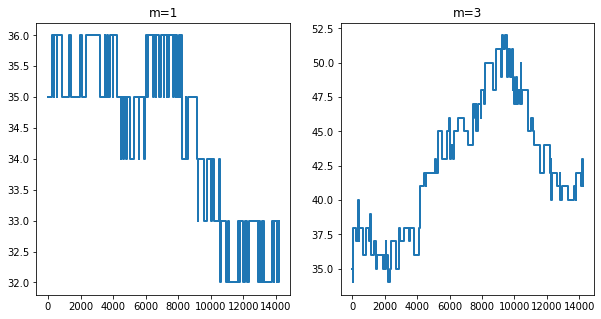

In [0]:
def sauts(N,saut,P0,alpha,T): 
    increments = saut(N)
    signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
    signes[0] = -1+np.random.binomial(1,0.5)*2
    signes = np.cumprod(signes)
    prix = P0 +np.cumsum(increments*signes)
    t=np.random.uniform(low=0,high=T,size=N+1)
    t[0]=0
    t.sort()
    t = np.concatenate((t,t[-1:]))
    return t,np.concatenate((np.concatenate((np.array([P0]),prix)),prix[-1:]))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

t1,prix1= sauts(N,saut_1,P0,alpha,T)
plt.step(t1, prix1, where="post", linewidth=2.0)

plt.title("m=1", fontsize=12)

plt.subplot(1, 2, 2)
t2,prix2= sauts(N,saut_2,P0,alpha,T)
plt.step(t2, prix2, where="post", linewidth=2.0)

plt.title("m=3", fontsize=12)



### Question 3.1 : Probabilité que le prix prenne des valeurs négatives au cours de N variations

####Monte-Carlo naïf - Méthode 1


In [0]:
def Q3_proba_negatif(N,saut,P0,M,alpha): 
    liste_px_inf_0 = np.zeros(M)
    for i in range(M):
        increments = saut(N)
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        prix = P0 +np.cumsum(increments*signes)
        if np.min(prix)<0:
            liste_px_inf_0[i] = 1
        liste_px_inf_0[i] = 0
    return np.mean(liste_px_inf_0)


In [0]:
M= int(1e5)

proba_negatif = Q3_proba_negatif(N,saut_2,P0,M,alpha) 
R_IC = 1.96*np.sqrt(proba_negatif*(1-proba_negatif)/M)
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts pour m=3: {}+/- {}".format(np.mean(proba_negatif),R_IC))

Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : 0.0+/- 0.0


#### Méthode 2 - Mutation/Sélection


In [0]:
def part_interaction(N,saut,P0,M,alpha,mu):
    #mu: paramètre des poids G_p
    # Tirages de M x N v.a. suivant la loi "saut" et de MxN v.a. delta_n représentant le changement de signe du saut par rapport au signe du saut précédent
    # seront utilisees pour construire les chaînes de Markov
    xi= saut(M, N)   #N: horizon temporel (nombre de sauts)
    delta = -1+2*np.random.binomial(1,(1+alpha)/2,size=(M,N-1))

    ###############################################################################
    ## En ponderant les trajectoires hautes : Estimation via G(X)=e^{alpha X_p}
    ###############################################################################

    # P stocke TOUTES LES VALEURS pour chacune des M chaines, dans l'optique du calcul de G_p 
    # J_hat stocke la dernière valeur du signe de saut (saut vers le bas ou vers le haut) pour chacune des M chaînes
    P = np.zeros((M,N))

    J_hat = -1+2*np.random.binomial(1,0.5,size=M) #le premier saut est vers le bas ou vers le haut avec la même probabilité

    # On initialise avec la valeur du prix après le premier saut
    P[:,0] = P0+J_hat*xi[:,0]
        
    facteurDroite = 1 #produit des moyennes des pondérations à chaque itération

    for k in range(N-1):
                
        weights = np.exp(-mu*P[:,k])
        
        facteurDroite *= np.mean(weights)
        
        
        weights = weights/np.sum(weights)

        I = np.random.choice(np.arange(M),size=M,replace=True,p=weights)
        
        #sélection
        P = P[I,:]
        J_hat=J_hat[I]

        #mutation

        J_hat=J_hat*delta[:,k]
        P[:,k+1] = P[:,k] +xi[:,k+1]*J_hat

    #px_final_moyen=np.mean(P[:,-1]) #sert pour ajuster mu en essayant d'obtenir un prix final proche de 0
    #print(px_final_moyen)
    tabFacteursGauche = np.exp(mu*np.sum(P[:,:-1],axis=1)) #tableau des 1/(\prod_{k=0}^{N-2} G_k)
    proba_negatif = np.sum(tabFacteursGauche[np.min(P,axis=1)<0])/M * facteurDroite
    return proba_negatif

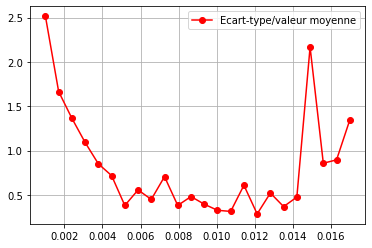

In [0]:
#Optimisation de mu 

M= int(1e4)
P0= 35
N=100
n=10
liste_mu = np.linspace(0.001,0.017,24)
estimateurs = np.zeros((len(liste_mu),n))

for i in range(len(liste_mu)):
    for j in range(n):
        estimateurs[i,j]=part_interaction(N,saut_2_vect,P0,M,alpha,liste_mu[i])

plt.plot( liste_mu,np.std(estimateurs,axis=1)/np.mean(estimateurs,axis=1),'r-o',label="Ecart-type/valeur moyenne")

plt.grid()
plt.legend()

In [0]:
#m=3

M= int(1e5)
P0= 35
N=100
mu = 0.008 #ajusté empiriquement
L= 10

#proba_negatif = Q3_proba_negatif(N,saut_2,P0,M,alpha) #pour utiliser la méthode naïve
#proba_negatif = part_interaction(N,saut_2_vect,P0,M,alpha,mu) #pour utiliser la méthode mutation/selection

probas_negatif = np.zeros(L)
for l in range(L):
    probas_negatif[l] = part_interaction(N,saut_2_vect,P0,M,alpha,mu)
R_IC= np.sqrt(np.var(probas_negatif)/L)*sps.t.ppf(0.975,df=L-1) #quantile de la loi de Student 
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : {}+/- {}".format(np.mean(probas_negatif),R_IC))

#Pour P0=10 et m=3 et M=10^5 et N=100, donne 0.2262 avec MC naif
#Donne 0.2331 avec méthode particules en interaction (mu=0.03/P0)
#pour P0=35, particules en interaction donne 5.027933935719282e-05

Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : 4.3861299566524465e-05+/- 4.8507714448079495e-06


### Question 3.2 : Quantiles du prix final après N variations

In [0]:
#Quantile simple 


def Quantile_naif_2(seuil,N,saut,P0,M,alpha):

    liste_P_t = np.zeros(M)
    for i in range(M):
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        increments = saut(N)
        
        liste_P_t[i] = np.sum(increments*signes)+P0 
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(M*seuil))-1],liste_P_t[int(np.ceil(M*(1-seuil)))-1]

In [0]:
seuil = 1e-5
M=int(1e5)
nbIter = 30
quantiles = np.zeros((nbIter,2))

for i in range(nbIter):
    quantiles[i][0],quantiles[i][1] = Quantile_naif_2(seuil,N,saut_2,P0,M,alpha)

estimateur_quantiles = np.mean(quantiles,axis=0)
erreur = np.std(quantiles,axis=0)/np.sqrt(nbIter)
print("Quantiles gauche et droit de niveau {} : ({} +/ {:08.7f}, {} +/ {})".format(seuil,estimateur_quantiles[0],erreur[0],estimateur_quantiles[1],erreur[1]))

Quantiles gauche et droit de niveau 1e-05 : (-3.1333333333333333 +/ 0.4156209, 71.43333333333334 +/ 0.2969599050127562)


## __Question 4 : Limite macroscopique__

In [0]:
T = 8*250*60*60
lamb = 1/300
P0=1000
alpha=-0.875

saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: np.random.choice([1, 2, 3], size=x, replace=True, p=np.array([1/2, 1/3, 1/6])) #correspond à m=3

#Pour mutation/sélection
saut_1_vect = lambda x,y : np.ones(shape=(x,y))
saut_2_vect = lambda x,y: np.random.choice([1, 2, 3], size=(x,y), replace=True, p=np.array([1/2, 1/3, 1/6])) 

### Simulation de trajectoire

Text(0.5, 1.0, 'm=3')

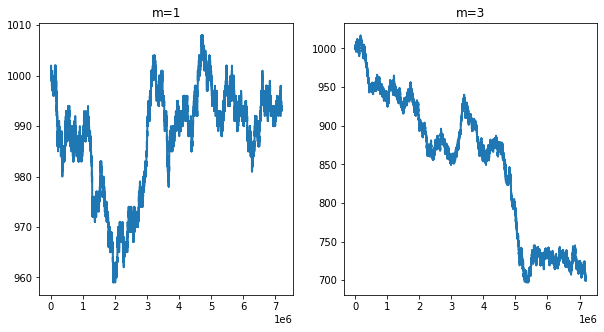

In [0]:
#Comme dans la question 3 mais à horizon temporel fixé au lieu d'être à nombre de sauts N fixé

def sauts(lamb,saut,P0,alpha,T):
    N0 = np.random.poisson(T*lamb) 
    increments = saut(N0)
    signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N0)
    signes[0] = -1+np.random.binomial(1,0.5)*2
    signes = np.cumprod(signes)
    prix = P0 +np.cumsum(increments*signes)
    t=np.random.uniform(low=0,high=T,size=N0+1)
    t[0]=0
    t.sort()
    t = np.concatenate((t,t[-1:]))
    return t,np.concatenate((np.concatenate((np.array([P0]),prix)),prix[-1:]))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

t1,prix1= sauts(lamb,saut_1,P0,alpha,T)
plt.step(t1, prix1, where="post", linewidth=2.0)

plt.title("m=1", fontsize=12)

plt.subplot(1, 2, 2)
t2,prix2= sauts(lamb,saut_2,P0,alpha,T)
plt.step(t2, prix2, where="post", linewidth=2.0)

plt.title("m=3", fontsize=12)

Text(0.5, 1.0, 'm=3')

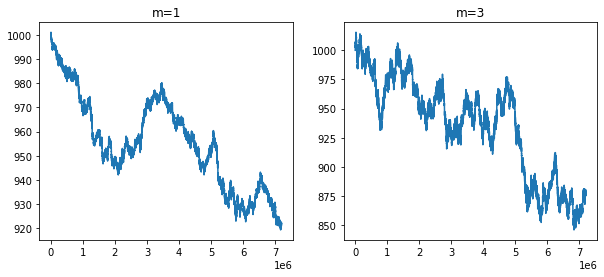

In [0]:
#Limite macroscopique

def prix(N,T,lamb,alpha,m):
    sigma_inf_carre = lamb
    if m==1:
        sigma_inf_carre *=(1+alpha)/(1-alpha)
    else:
        sigma_inf_carre *= (5./9.+25./9.*(1+alpha)/(1-alpha))

    mvt_bro = np.random.normal(loc=0,scale=1,size=N)

    P_discret = P0+ np.sqrt(sigma_inf_carre*T/N)*np.cumsum(mvt_bro)

    return P_discret

N=int(1e5)


t = np.linspace(0,T,N+1)
P1 = np.concatenate((np.array([P0]),prix(N,T,lamb,alpha,1))) #m=1
P3 = np.concatenate((np.array([P0]),prix(N,T,lamb,alpha,3))) #m=3



plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t,P1)
plt.title("m=1", fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(t,P3,label="m=3")
plt.title("m=3", fontsize=12)


### Question 4.1 : Estimation de la probabilité d'un prix négatif

####Méthode 1 - Monte-Carlo sur le prix "non macroscopique" (identique à la méthode de Monte-Carlo de la question Q3.1 mais à horizon temporel T fixé au lieu d'être à nombre de sauts N fixé)


In [0]:
def Q3_proba_negatif(lamb,T,saut,P0,M,alpha): 
    liste_px_inf_0 = np.zeros(M)
    for i in range(M):
        N = np.random.poisson(lamb*T)
        increments = saut(N)
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        prix = P0 +np.cumsum(increments*signes)
        
        if np.min(prix)<0:
            liste_px_inf_0[i] = 1

    return np.mean(liste_px_inf_0)

In [0]:
%%time

M = int(1e4)


proba_negatif = Q3_proba_negatif(lamb,T,saut_2,P0,M,alpha)
print(proba_negatif)

0.0
CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


####Méthode 2: Monte-Carlo sur la simulation par limite brownienne


In [0]:
def brownien(N,T,M,lamb,alpha,m):
    sigma_inf_carre = lamb
    if m==1:
        sigma_inf_carre *=(1+alpha)/(1-alpha)
    else:
        sigma_inf_carre *= (5./9.+25./9.*(1+alpha)/(1-alpha))

    mvt_bro = np.random.normal(0,1,size=(M,N))

    P_discret = P0+ np.sqrt(sigma_inf_carre*T/N)*np.cumsum(mvt_bro,axis=1)
    negatif = P_discret >=0 #matrix of booleans: True if and only if the price is positive
    exists_negatif = 1-np.prod(negatif,axis=1) #exists_negatif[i]=1 if and only if one of the N prices is negative for sample i (with 1 <=i <=M)

    return np.mean(exists_negatif)


In [0]:
M = int(1e6)

m=1

N=int(1e3)

proba_negatif=brownien(N,T,M,lamb,alpha,m)
print(proba_negatif)


0.0


####Méthode 3 - Sélection/Mutation sur la simulation par limite brownienne


In [0]:
def part_interaction(N,saut,P0,M,alpha,mu,m):

    sigma_inf_carre = lamb
    if m==1:
        sigma_inf_carre *=(1+alpha)/(1-alpha)
    else:
        sigma_inf_carre *= (5./9.+25./9.*(1+alpha)/(1-alpha))
    #mu: paramètre des poids G_p
    # Tirages de M x N v.a. suivant la loi normale 
    xi= np.random.normal(0,1,size=(M, N))   #N: horizon temporel (nombre de sauts)

    ###############################################################################
    ## En ponderant les trajectoires basses : Estimation via G(X)=e^{alpha X_k}
    ###############################################################################

    # X stocke TOUTES LES VALEURS pour chacune des M chaines, dans l'optique du calcul de G_p 
    Y = np.zeros((M,N))


    # On initialise avec P0*sqrt(N/T/sigma_inf_carre) + premier incrément gaussien
    Y[:,0] = P0*np.sqrt(N/T/sigma_inf_carre) + xi[:,0]
        
    facteurDroite = 1 #produit des moyennes des pondérations à chaque itération

    for k in range(N-1):
                
        weights = np.exp(-mu*Y[:,k])
        
        facteurDroite *= np.mean(weights)
        
        
        weights = weights/np.sum(weights)

        I = np.random.choice(np.arange(M),size=M,replace=True,p=weights)
        
        #sélection
        Y = Y[I,:]

        #mutation

        Y[:,k+1] = Y[:,k] +xi[:,k+1]

    #final_moyen=np.mean(Y[:,-1]) #sert pour ajuster mu en essayant d'obtenir un Y final proche de 0
    #print(final_moyen)
    tabFacteursGauche = np.exp(mu*np.sum(Y[:,:-1],axis=1)) #tableau des 1/(\prod_{k=0}^{N-2} G_k)
    proba_negatif = np.sum(tabFacteursGauche[np.min(Y,axis=1)<0])/M * facteurDroite
    return proba_negatif

In [0]:
#m=3

M= int(1e5)
N=100
mu = 0.03


#proba_negatif = part_interaction(N,saut_2_vect,P0,M,alpha,mu,3) 

L= 20
probas_negatif = np.zeros(L)
for l in range(L):
    probas_negatif[l] = part_interaction(N,saut_2_vect,P0,M,alpha,mu,3)
R_IC= np.sqrt(np.var(probas_negatif)/L)*sps.t.ppf(0.975,df=L-1) #quantile de la loi de Student 
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : {}+/- {}".format(np.mean(probas_negatif),R_IC))


#1.0660719478996492e-14+/- 8.568480036702792e-15 pour M=10^4 mu = 0.03 N=100 L=50

Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : 2.8755523968515452e-15+/- 1.2304271976127318e-15


### Question 4.2 : Estimation de quantiles

In [0]:
#Quantiles théoriques

alpha = 1e-6

#m=1
sigma_inf =np.sqrt(lamb * (1+alpha)/(1-alpha))
quantileGauche =P0+ np.sqrt(T)*sigma_inf*sps.norm.ppf(alpha)
quantileDroit = P0+np.sqrt(T)*sigma_inf*sps.norm.ppf(1-alpha)
print("Quantiles de niveau {} pour m=1 : ({}, {})".format(alpha,quantileGauche,quantileDroit))

#m=3
sigma_inf =np.sqrt(lamb * (5./9.+25./9.*(1+alpha)/(1-alpha)))
quantileGauche = P0+np.sqrt(T)*sigma_inf*sps.norm.ppf(alpha)
quantileDroit = P0+np.sqrt(T)*sigma_inf*sps.norm.ppf(1-alpha)
print("Quantiles de niveau {} pour m=3 : ({}, {})".format(alpha,quantileGauche,quantileDroit))

Quantiles de niveau 1e-06 pour m=1 : (-2607.5990078592777, 4607.5990078548675)
Quantiles de niveau 1e-06 pour m=3 : (-5586.5434190361975, 7586.543419028146)
